# Revisión y exploración de bases de datos.

## Importación librerías

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Importación bases de datos

In [2]:
# Games
games = pd.read_parquet("../Data/final/games_final.parquet")
# Reviews
reviews = pd.read_parquet("../Data/final/reviews_final.parquet")
# Items
items = pd.read_parquet("../Data/final/items_final.parquet")

## Exploración

In [ ]:
# Se deciden unir todas las bases de datos en un mismo dataframe en el que se especifiquen: 
    # Horas totales jugadas para el juego.
    # Número de recomendaciones (Recommend = True)
    # Número de no recomendaciones (Recommend = False)
    # Puntaje de análisis de sentimiento (sentiment_analysis)

In [24]:
# Con este propósito, se identifica el número de recomendaciones positivas por juego:
positivas = reviews[reviews["recommend"] == True]
positivas = positivas.groupby("item_id")["recommend"].count().reset_index()

# El número de recomendaciones negativas:
negativas = reviews[reviews["recommend"] == False]
negativas = negativas.groupby("item_id")["recommend"].count().reset_index()

# El puntaje de análisis de sentimiento:
sentimiento = reviews[["item_id","sentiment_analysis"]]
sentimiento = sentimiento.groupby("item_id").sum().reset_index()

# Las horas totales jugadas por juego
horas = items.groupby("item_id")["playtime_forever"].sum().reset_index()


In [62]:
# Se crea el dataframe uniendo la información obtenida en el punto anterior.
tot1 = pd.merge(games,positivas,how="left",left_on="id",right_on="item_id") # Se une games y sus resultados de reviews positivas.
tot2 = pd.merge(tot1,negativas,how="left",left_on="id",right_on="item_id") # Se unen el dataframe total (tot) con los resultados de las reviews negativas.
tot3 = pd.merge(tot2,sentimiento,how="left",left_on="id",right_on="item_id") # Se unen el dataframe total con los resultados del análisis de sentimiento.
tot3.drop(columns=["item_id_x","item_id_y","item_id"],inplace=True) # Se eliminan del dataframe total las columnas repetidas de item_id.
total = pd.merge(tot3,horas,how="left",left_on="id",right_on="item_id") # Se unen el dataframe total con los resultados de la suma de horas totales jugadas por juego.
total.drop(columns="item_id",inplace=True) # Se elimina la columna repetida de item_id.

# Se cambian los nombres de las columnas para que sean más representativas
total.rename(columns={"recommend_x":"recommend","recommend_y":"no_recommend"},inplace=True)

# Se eliminan del dataframe todos los juegos que no tengan información en ninguno de los 4 datos agregados (recommend, no_recommend, sentiment_analysis, playtime_forever)
total_l = total.dropna(subset=["recommend","no_recommend","sentiment_analysis","playtime_forever"],how="all")

In [68]:
# Se observa el dataframe final
total_l

,id,genres,app_name,release_date,recommend,no_recommend,sentiment_analysis,playtime_forever
0,10,[Action],Counter-Strike,2000-11-01,29.0,1.0,50.0,51279.69
1,20,[Action],Team Fortress Classic,1999-04-01,6.0,5.0,17.0,6363.10
2,30,[Action],Day of Defeat,2003-05-01,3.0,NaN,5.0,6596.96
3,40,[Action],Deathmatch Classic,2001-06-01,1.0,NaN,2.0,845.33
4,50,[Action],Half-Life: Opposing Force,1999-11-01,3.0,1.0,5.0,5082.69
...,...,...,...,...,...,...,...,...
18068,526460,"[Action, Adventure, Casual, Indie]",KickHim,2016-09-10,NaN,NaN,NaN,0.02
18113,527340,"[Action, Indie]",What The Box?,2016-09-12,1.0,NaN,2.0,9.06
18130,527510,"[Casual, Indie, Simulation, Strategy]",The Legions of Rome,2016-09-16,NaN,NaN,NaN,3.10
18142,527890,"[Casual, Simulation]",Shop-n-Spree: Shopping Paradise,2016-09-12,NaN,NaN,NaN,0.02


In [65]:
# Se observa información sobre la base obtenida.
total_l.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7739 entries, 0 to 18143
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  7739 non-null   int64         
 1   genres              7739 non-null   object        
 2   app_name            7739 non-null   object        
 3   release_date        7739 non-null   datetime64[ns]
 4   recommend           2481 non-null   float64       
 5   no_recommend        1169 non-null   float64       
 6   sentiment_analysis  2771 non-null   float64       
 7   playtime_forever    7523 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 544.1+ KB


In [69]:
# Se ve la información estadística de las variables nominales.
total_l.describe()

,id,release_date,recommend,no_recommend,sentiment_analysis,playtime_forever
count,7739.000000,7739,2481.000000,1169.000000,2771.000000,7.523000e+03
mean,296783.455098,2013-06-07 04:08:57.743894528,13.300282,3.608212,20.233129,3.608617e+03
min,10.000000,1983-06-19 00:00:00,1.000000,1.000000,0.000000,2.000000e-02
25%,243460.000000,2012-10-16 00:00:00,1.000000,1.000000,2.000000,9.800000e+00
50%,324160.000000,2015-01-26 00:00:00,2.000000,1.000000,3.000000,5.430000e+01
75%,390300.000000,2015-12-15 00:00:00,6.000000,3.000000,9.000000,2.475350e+02
max,527900.000000,2018-12-01 00:00:00,2323.000000,212.000000,3878.000000,4.800734e+06
std,134100.818751,NaN,77.559450,10.480190,120.127564,7.106010e+04


Se desean conocer las variaciones de los diferentes tipos de datos por la categoría a la que pertenecen.

In [83]:
# Se hace un explode en los géneros con el propósito de conocer variaciones en los datos por género.
total_generos = total_l.explode("genres")
total_generos = total_generos.groupby(["genres","id"])[["recommend","no_recommend","sentiment_analysis","playtime_forever"]].sum().reset_index()

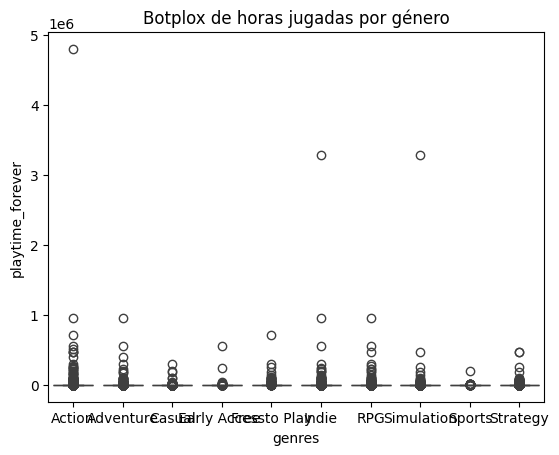

In [84]:
# Por el total de horas jugadas.
sns.boxplot(data=total_generos,x="genres",y="playtime_forever")
plt.title("Botplox de horas jugadas por género")
plt.show()

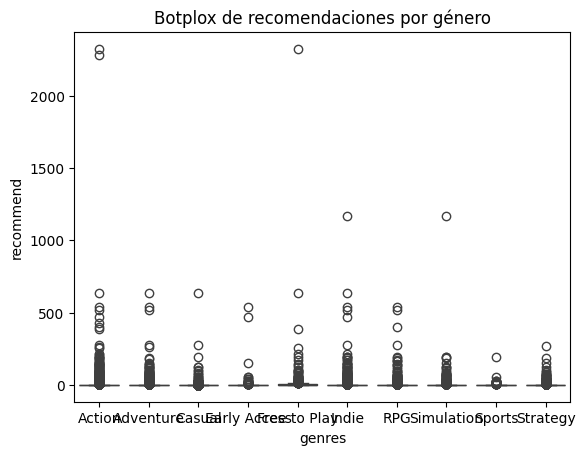

In [85]:
# Por el total de recomendaciones.
sns.boxplot(data=total_generos,x="genres",y="recommend")
plt.title("Botplox de recomendaciones por género")
plt.show()